# Classification

## Modelling a baseline model using DummyClassifier

The objective here is to make a baseline model for our classification task so that we could iterate on it and compare our best model against it

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier 
from sklearn.metrics import(
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

RANDOM_STATE = 17

In [5]:
try:
    df = pd.read_csv("../data/COMP1801_Coursework_Dataset_Corrected.csv")
except FileNotFoundError:
    print(f"Error: Dataset file not found!")
    exit()
df.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,1107.81,Valve,singleGrain,27,2.64,8.08,23.35,60.65,19.76,15.18,4.41,7,0,0,Top,Investment
1,1226.13,Valve,colGrain,24,4.06,1.11,24.98,52.47,31.63,12.32,3.58,30,1,0,Top,Continuous
2,1914.12,Blade,singleGrain,20,4.36,8.54,34.71,60.98,26.56,11.60,0.86,22,0,0,Bottom,Continuous
3,1240.83,Valve,singleGrain,14,3.59,8.83,21.61,54.13,26.71,17.81,1.35,10,0,0,Bottom,Continuous
4,1599.40,Nozzle,singleGrain,22,3.06,3.04,29.65,62.88,24.06,12.08,0.98,21,0,0,Top,Investment


--- Class Distribution ---
1500_labels
0    0.711
1    0.289
Name: proportion, dtype: float64




C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16380\2327927296.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='1500_labels', data=df, palette='pastel', hue=None)


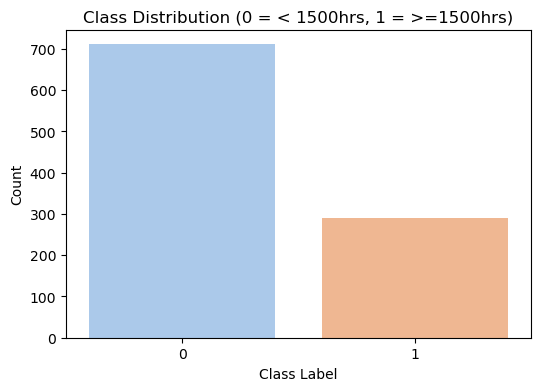

In [10]:
# let us create the binary feature for out classification where threshold == 1500

LIFESPAN_THRESHOLD = 1500
df['1500_labels'] = (df['Lifespan'] >= LIFESPAN_THRESHOLD).astype(int)

# plot & check class balance of TRUE/FALSE (1 or 0)
print("--- Class Distribution ---")
print(df['1500_labels'].value_counts(normalize=True))
print("\n")

plt.figure(figsize=(6, 4))
sns.countplot(x='1500_labels', data=df, palette='pastel', hue=None)
plt.title(f"Class Distribution (0 = < {LIFESPAN_THRESHOLD}hrs, 1 = >={LIFESPAN_THRESHOLD}hrs)")
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.savefig("../report/figures/fig-4.1-class-distribution.png", dpi=500, bbox_inches="tight")
plt.show()

### Class Distribution observations:

1. There is a **strong class imbalance** in the dataset
2. Classes 0:1 has a proportion of nearly **7:3** which is highly imbalanced in the favour of class 0
3. We must make up for this class imbalance using either minority over-sampling or majority undersampling, etc. 
4. Need for right metric **(F1 score, recall)** that shows minority performance 

### pre-processing 

In [11]:
y = df['1500_labels']
X = df.drop(columns=['Lifespan', '1500_labels'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, random_state=RANDOM_STATE
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("-"*30)

Training set shape: (800, 15)
Test set shape: (200, 15)
------------------------------


In [14]:
cat_col = X_train.select_dtypes(include=['object','category']).columns.tolist()
num_col = X_train.select_dtypes(include=['int64','float64']).columns.tolist()

print(f"Categorical columns: {cat_col}")
print(f"Numerical columns: {num_col}")
print("-"*30)

Categorical columns: ['partType', 'microstructure', 'seedLocation', 'castType']
Numerical columns: ['coolingRate', 'quenchTime', 'forgeTime', 'HeatTreatTime', 'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%', 'smallDefects', 'largeDefects', 'sliverDefects']
------------------------------



--- Dummy Classifier (Baseline) Results ---
Dummy Accuracy:  0.7150
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       143
           1       0.00      0.00      0.00        57

    accuracy                           0.71       200
   macro avg       0.36      0.50      0.42       200
weighted avg       0.51      0.71      0.60       200

------------------------------
Logistic Regression Accuracy: 0.7300
Logistic Regression Precision: 0.6000
Logistic Regression Recall: 0.1579
Logistic Regression F1-Score: 0.2500

Full Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       143
           1       0.60      0.16      0.25        57

    accuracy                           0.73       200
   macro avg       0.67      0.56      0.54       200
weighted avg       0.70      0.73      0.67       200



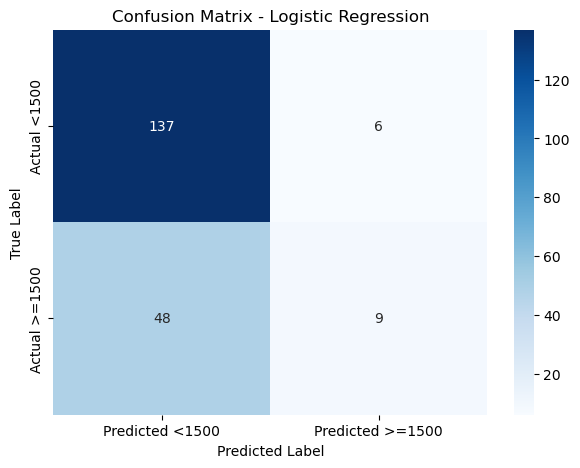

In [18]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler',StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, cat_col)
    ],
    remainder='passthrough'
)

print("\n--- Dummy Classifier (Baseline) Results ---")
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)
y_dummy_pred = dummy_clf.predict(X_test)

print(f"Dummy Accuracy: {accuracy_score(y_test, y_dummy_pred): .4f}")
print(classification_report(y_test, y_dummy_pred, zero_division=0))
print("-"*30)

baseline_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', baseline_model)
])

clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Precision: {precision:.4f}")
print(f"Logistic Regression Recall: {recall:.4f}")
print(f"Logistic Regression F1-Score: {f1:.4f}")

print("\nFull Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted <1500', 'Predicted >=1500'], 
            yticklabels=['Actual <1500', 'Actual >=1500'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.savefig("../report/figures/fig-4.2-baseline-classifier-report.png", dpi=500, bbox_inches='tight')
plt.show()

### Baseline classifier result observations:

1. As we hypothesised, the baseline only predicts class 0
2. Even though accuracy is fine, we see the real picture when we see precision and recall being terribly bad
2. Logistic Regression does learn to predict class 1 but does not do well in containing the effects of imbalanced dataset